In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv("hotel_bookings.csv").rename(columns={'arrival_date_year':'year',
                                                       'arrival_date_month':'month',
                                                       'arrival_date_day_of_month':'day'})

In [2]:
percent_missing = df.isnull().sum() * 100 / len(df)
df2 = pd.DataFrame({'percent_missing': percent_missing})
df2.loc[df2['percent_missing'] != 0.0]

,percent_missing
children,0.003350
country,0.408744
agent,13.686238
company,94.306893


In [3]:
df.drop(columns=['company','agent'], inplace=True)
df.dropna(subset=['country'], inplace=True)
df['children'].fillna(df['children'].mode()[0], inplace=True)
df.head()

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
#Change the month name for value
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

df['month'] = df['month'].apply(monthToNum)
df['date']= pd.to_datetime(df[["year", "month", "day"]])

In [5]:
df = df[(df['is_canceled']==0)]
booking = df.groupby(['date'])['date'].count().reset_index(name='n_bookings')

In [6]:
fig = px.line(booking, x="date", y="n_bookings", title='booking demands daily')
fig.show()

In [7]:
booking2 = booking.resample(rule='M', on='date')['n_bookings'].sum()
booking2 = booking2.reset_index()

In [8]:
fig = px.line(booking2, x="date", y="n_bookings", title='hotel demands monthly')
fig.show()

In [9]:
#Split the data

train_df = booking.loc[(booking['date']>='2015-07-01') & (booking['date']<'2017-08-01')]
test_df = booking.loc[(booking['date']>='2017-08-01') & (booking['date']<'2017-09-01')]

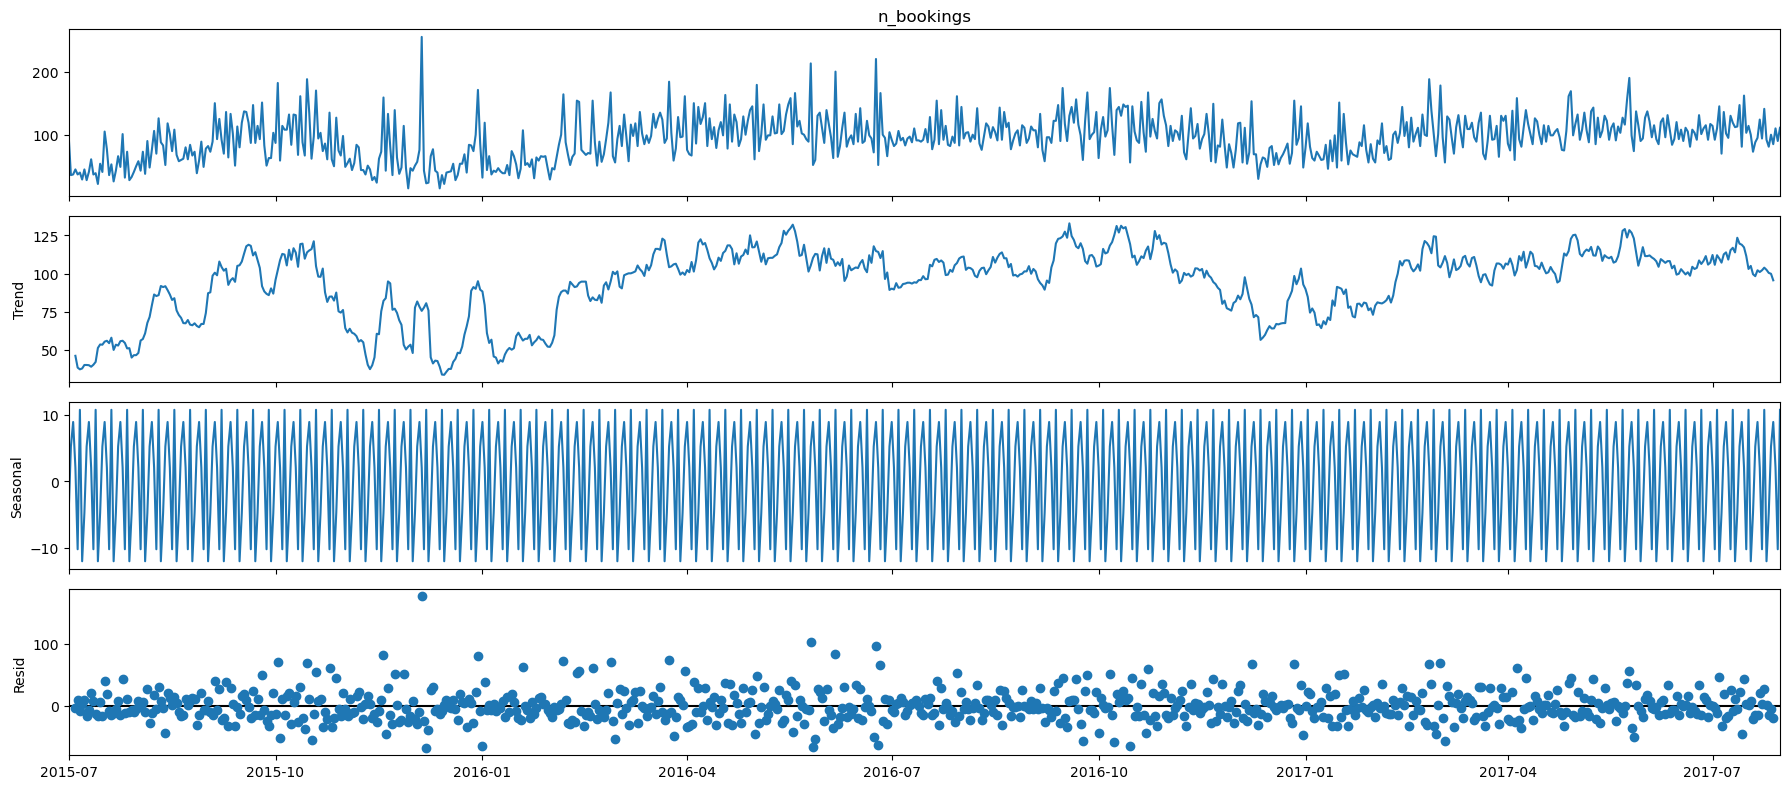

In [10]:
from pylab import rcParams
import statsmodels.api as sm

train_df_arima = train_df.copy()
train_df_arima = train_df_arima.set_index('date')

test_df_arima = test_df.copy()
test_df_arima = test_df_arima.set_index('date')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(train_df_arima['n_bookings'], 
                                          model='additive')
fig = decomposition.plot()
plt.show()

In [11]:
from statsmodels.tsa.ar_model import ar_select_order
search_lag = ar_select_order(endog=train_df_arima, maxlag=90 ,seasonal=True)
search_lag.ar_lags

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



[1, 2, 3, 4, 5, 6, 7]

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

test_series = list(test_df_arima['n_bookings'])

#Train autoregression
model = AutoReg(train_df_arima, lags=90, seasonal=True)
model_fit = model.fit()
forecast_90days = model_fit.forecast(steps=31)


# make predictions
model = AutoReg(train_df_arima, lags=7, seasonal=True)
model_fit = model.fit()
forecast_7days = model_fit.forecast(steps=31)

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\HPEMR\anaconda3\lib\site-packages\statsmodels\tsa\determi

In [13]:
#Compare RMSE
rmse = sqrt(mean_squared_error(test_series, forecast_7days))
print('Test RMSE: %.3f' % rmse)

rmse = sqrt(mean_squared_error(test_series, forecast_90days))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.569
Test RMSE: 18.067


In [14]:
#print(model_fit.summary())

In [15]:
import plotly.graph_objects as go

# Create traces for actual, previous, and predicted data
trace_actual = go.Scatter(x=test_df['date'], y=test_df['n_bookings'], mode='lines', name='Actual')
trace_predicted_7days = go.Scatter(x=forecast_7days.index, y=forecast_7days.values, mode='lines', name='Predicted based 7 days prior')
trace_predicted_90days = go.Scatter(x=forecast_90days.index, y=forecast_90days.values, mode='lines', name='Predicted based 90 days prior')

# Create layout
layout = go.Layout(title='Actual vs Predicted',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='n_bookings'),
                   legend=dict(x=0, y=1, traceorder='normal'))

# Create figure and add traces
fig = go.Figure(data=[trace_actual, trace_predicted_7days, trace_predicted_90days], layout=layout)

# Show the figure
fig.show()
